In [1]:
%load_ext jupyternotify

import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
from scipy.constants import e, k, h
from scipy.interpolate import interp1d
import itertools
import numba
from numba import jit
from numba.core import types
from numba.typed import Dict
from scipy.optimize import minimize, basinhopping
rok_energy = 1e-3*e
Delta = 0.166*1e-3*e

<IPython.core.display.Javascript object>

In [2]:
@jit(nopython=True)
def gamma(g0, v0, T, N):
    numerator = np.exp(v0/(k*T)) + N
    denominator = np.exp(v0/(k*T)) - 1
    return g0*numerator/denominator

@jit(nopython=True)
def etta(g0, v0, T, N):
    numerator = N*gamma(g0, v0, T, N)
    denominator = 4*k*T*((np.cosh(v0/(2*k*T)))**2)
    return numerator/denominator

@jit(nopython=True)
def llambda(v0, T, N):
    numerator = np.exp(v0/(k*T)) + 1
    denominator = np.exp(v0/(k*T)) + N
    return numerator/denominator
    

In [3]:
@jit(nopython=True)
def p0(smg, T, N):
    numerator = np.exp(smg/(k*T))
    denominator = np.exp(smg/(k*T)) + N
    return numerator/denominator

@jit(nopython=True)
def q_capacitance(smg, T, N, dne, dng):
    return (e**2) * (p0(smg, T, N)*(dng - dne) + dne)

@jit(nopython=True)
def tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ng - ne)*gamma(g0, smg, T, N)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

@jit(nopython=True)
def total_capacitance(g0, smg, dsmg, T, N, ne, ng, dne, dng, w):
    return tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w) + q_capacitance(smg, T, N, dne, dng)

@jit(nopython=True)
def I_resistance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ng - ne)*(w**2)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

In [4]:
dirpath = f"f1web.ijs.si\\~zitko\\data\\chi\\"
Uset = tuple(np.sort([float(file_names[2:]) for file_names in os.listdir(dirpath) if file_names[0:2]=='U=']))

Gamma_dict = tuple([np.array([file_names.split('=')[-1]
                         for file_names in os.listdir(dirpath+f'U={Uvals}')
                         if file_names[0:2]=='U=']) for Uvals in Uset])

@jit(nopython=True)
def Gamma_dict_func(U):
    for idx, Uvals in enumerate(Uset):
        if Uvals==U:
            return Gamma_dict[idx]

In [5]:
optical1_data = tuple([np.array(
    [
        np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
        for gammaa in Gamma_dict_func(Uvals)
    ]) for Uvals in Uset])

n1_data = tuple([np.array(
    [
        np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
        for gammaa in Gamma_dict_func(Uvals)
    ]) for Uvals in Uset])

n2_data = tuple([np.array(
    [
        np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
        for gammaa in Gamma_dict_func(Uvals)
    ]) for Uvals in Uset])


In [6]:
@jit(nopython=True)
def optical_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return optical1_data[Uset.index(U)][idx,:,:]

@jit(nopython=True)
def n1_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return n1_data[Uset.index(U)][idx,:,:]
        
@jit(nopython=True)
def n2_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return n2_data[Uset.index(U)][idx,:,:]
        
@jit(nopython=True)
def rok_data_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return optical1_data[Uset.index(U)][idx,:,:], n1_data[Uset.index(U)][idx,:,:], n2_data[Uset.index(U)][idx,:,:]
        

In [7]:
path = "G:\\My Drive\\GROWTH\\Quantum computing\\Majorana Project\\Experimental data\\data-oct4-21-mail-filip\\data\\"
dset_list2 = np.array(["00","01","02","03","04","05", "06", "07", "08", "09","10"])
dataset_data2 = np.array(
    [
        np.loadtxt(
            f"{path}dataset_opening_{dset}.csv",
            skiprows=1,
            delimiter=','
        )[:,[0,1,5]] for dset in dset_list2
    ]
)

In [8]:
@jit(nopython=True)
def dataset_capfunc(dset):
    for idx in range(len(dset_list2)):
        if dset_list2[idx]==dset:
            return dataset_data2[idx,:,0:2]

@jit(nopython=True)
def dataset_resfunc(dset):
    for idx in range(len(dset_list2)):
        if dset_list2[idx]==dset:
            return dataset_data2[idx,:,0:3:2]

In [9]:
@jit(nopython=True)
def expvals(dset,sym):
    rangeval = 0.605
    capset = dataset_capfunc(dset)
    resset = dataset_resfunc(dset)
    exp_caps = capset[:,1]
    exp_ires = 1/resset[:,1]
    vex = capset[:,0]*1e3
    
    filter_arry = (vex<(rangeval))*(-rangeval<vex)
    exp_caps = exp_caps[filter_arry]
    exp_ires = exp_ires[filter_arry]
    vex = vex[filter_arry]
    
    exp_caps = exp_caps*1e15
    exp_ires = np.abs(exp_ires)*1e8
    
    if sym:
        exp_caps = (exp_caps + exp_caps[::-1])/2
        exp_ires = (exp_ires + exp_ires[::-1])/2
    return vex, exp_caps, exp_ires


In [10]:
@jit(nopython=True)
def fitting_s2(gammaa,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    
#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
    op1,n1,_ = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, 0, dn_g)*1e15
    
    return Q_Caps

@jit(nopython=True)
def fitting_s3(gammaa,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)

#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    
    return Q_Caps

@jit(nopython=True)
def fitting_s4(gammaa,g0,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6

#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    ds_mg = (ds_mg + ds_mg[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    
    return Q_Caps + T_Caps

@jit(nopython=True)
def fitting_s5(gammaa,g0,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6

#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    C_total = Q_Caps + T_Caps
    
    Ires = -alpha*alpha*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8
    return C_total, Ires

In [11]:
@jit(nopython=True)
def fitting_s6(U,gammaa,g0,alpha,T,N,v0):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6
    
#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    C_total = Q_Caps + T_Caps
    
    Ires = -alpha*alpha*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8
    return C_total, Ires

In [12]:
@jit(nopython=True)
def fitting_s7(U,gammaa,g0,alpha,T,N,v0):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6
    
#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    C_total = Q_Caps + T_Caps
    
    Ires = -alpha*alpha*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8
    return C_total, Ires

# T_Caps = np.array([-alpha*alpha*tunnel_capacitance(g0vals, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15 for g0vals in g0])
# Ires = np.array([-alpha*alpha*I_resistance(g0vals, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8 for g0vals in g0])

In [137]:
@jit(nopython=True)
def weight_s7(U,dset,gammaa,g0,alpha,T,N,sym):
    expV, expC, expIR = expvals(dset, sym)
    theoC, theoIR = fitting_s7(U,gammaa,g0,alpha,T,N,expV)
    weitC = ((theoC - expC)**2)/(np.maximum(0.027,(theoC + expC)/2)**2)*(1 - np.abs(expV)/0.6)
    weitIR = ((theoIR - expIR)**2)/(np.maximum(1,(theoIR + expIR)/2)**2)*(1 - np.abs(expV)/0.6)

    return 2*(5*np.sum(weitIR) + np.sum(weitC))/6

@jit(nopython=True)
def total_weight_s7(U,dset,g0,alpha,T,N,sym):
    gset = Gamma_dict_func(U)
    weightset = np.array([weight_s7(U,dset,gama,g0, alpha,T,N,sym) for gama in gset])
    winweitidx = np.argmin(weightset)
    return gset[winweitidx], weightset[winweitidx]

@jit(nopython=True)
def total_set_weight_s7(params,sym,U):
    alpha,T,fac = params[-3:]
    g0set = params[:-3]
    dset_list = ["00","01","02","03","04","05", "06", "07", "08", "09","10"]
    allweightset = np.array([total_weight_s7(U,dset_list[idx],10**g0set[idx],alpha,T/100,10**fac,sym)[1] for idx in range(len(dset_list))])
    totalweight = np.sum(allweightset)
    return totalweight
    
def fitplot_s7(dset,g0,alpha,T,N,sym,U):
    expV, expC, expIR = expvals(dset,sym)
    
    gamma, weit = total_weight_s7(U,dset,g0,alpha,T,N,sym)
    print(gamma, weit)
    TheoC, TheoIR = fitting_s7(U,gamma,g0,alpha,T,N,expV)
    
    fig, axes = plt.subplots(1,2)
    axes[0].plot(expV, expC)
    axes[0].plot(expV, TheoC)
    axes[1].plot(expV, expIR)
    axes[1].plot(expV, TheoIR)
    print(np.mean(np.abs(TheoIR)))

In [120]:
# total_set_weight_s7(( 8.0, 0.32, 6.0, 6.0),1,0.333)

# total_set_weight_s7((10.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 0.32, 6.0, 6.0),1,0.333)
total_set_weight_s7((*(np.random.random(11)+10*np.random.random(11)), 0.5, 10.0, 6.0),1,0.333)

# [*(np.random.random(10)+10*np.random.random(10)),2,3]

1313.4079804274681

In [124]:
total_set_weight_s7((7.18782493,  6.53997609,  6.95178355,  7.42629289,  7.43277345,
                               7.83795479,  8.67289453,  9.11521502,  9.64710981,  9.04068084,
                               8.85824842,  0.62466789, 11.27579307,  5.69590558),1,0.416)
# total = 279.189185383901
# IR = 158.01416451327054
# C = 103.52017673636006


313.0886394491474

0.08000 19.185914586028066
0.9703811994168988


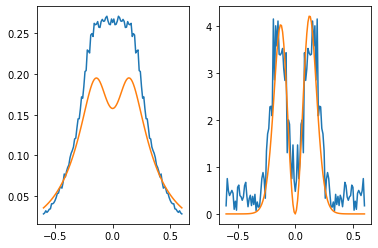

In [138]:
fitplot_s7('08', 10**8.5, 0.63, 11.28/100, 10**5.7, 1, 0.416)
# 0.06000 39.13429156850518
# 1.1838294768726663

In [17]:
def minimize_func(U):
    result_s7 = minimize(total_set_weight_s7, (8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 0.5, 10.0, 6.0),args=(1,U),method = 'trust-constr')
    return_set = [result_s7.success]
    if result_s7.success:
        return_set.append(result_s7.fun)
        return_set.append(result_s7.x)
    return return_set


In [19]:
%%time
bigres = []
for Uvals in Uset:
    setss = minimize_func(Uvals)
    print(setss)
    bigres.append(setss)

[True, 386.2421087810592, array([ 7.74091093,  6.73367804,  7.30181562,  8.30978492,  7.92078884,
        8.45564194,  9.41649929,  9.26809048,  9.5492374 ,  9.21875657,
       -0.37226   ,  8.54981102,  8.05836443])]
[True, 318.4701201932162, array([ 7.26378577,  6.4883212 ,  7.1108474 ,  7.41555352,  7.55577392,
        7.95150025,  9.30419655,  9.21480962,  9.49004179,  9.16315587,
       -0.52504177,  9.43554228,  8.83820646])]
[True, 280.78743006701865, array([ 7.4854951 ,  6.69497847,  7.18535669,  8.03051485,  7.73297009,
        8.15036665,  9.48059637,  9.27734832,  9.63022677,  9.1021408 ,
       -0.46834277,  8.54266247,  7.50918029])]
[True, 241.1287653993976, array([7.3092837 , 6.67820472, 7.08960324, 7.67868451, 7.59349551,
       8.02076879, 9.456796  , 9.17412884, 9.63465523, 9.0767071 ,
       0.54061819, 9.90477339, 5.67913829])]
[True, 237.39346567633862, array([ 7.07637981,  6.57906425,  6.89006911,  7.28075805,  7.44689093,
        7.831856  ,  8.48195073,  8.85902

In [18]:
def minimize_funch(U):
    result_sh = basinhopping(total_set_weight_s7, (8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 0.5, 10.0, 6.0),
                      niter=30, minimizer_kwargs={'args':(1,U),"method": 'trust-constr'})#, T=10, stepsize=2)
    return_set = [result_sh.lowest_optimization_result.success]
    if result_sh.lowest_optimization_result.success:
        return_set.append(result_sh.lowest_optimization_result.fun)
        return_set.append(result_sh.lowest_optimization_result.x)
    return return_set


In [142]:
def minimize_funch(U):
    inital_x = (7.2,  6.5,  6.9,  7.4,  7.4, 7.8,  8.7,  9.1,  9.6,  9.0, 8.9,  0.63, 11.28,  5.7)
    result_sh = basinhopping(total_set_weight_s7, inital_x,
                      niter=30, minimizer_kwargs={'args':(1,U),"method": 'trust-constr'})#, T=10, stepsize=2)
    return_set = [U, result_sh.lowest_optimization_result.success]
    if result_sh.lowest_optimization_result.success:
        return_set.append(result_sh.lowest_optimization_result.fun)
        return_set.append(result_sh.lowest_optimization_result.x)
    return return_set


In [143]:
%%time
bigresh = []
for Uvals in Uset[3:4]:
    print(Uvals)
    setss = minimize_funch(Uvals)
    print(setss)
    bigresh.append(setss)
# 202111241352 All data, 2c1r
# # 0.416
# # [0.416, True, 243.44746576054035, array([ 7.49267164,  6.50876169,  6.93912654,  8.03165217,  7.63191353,
# #         7.89749427,  8.61728879,  9.13932911,  9.67211507,  9.05615748,
# #         9.79518666,  0.61536863, 10.98127214,  5.48055907])]
# # Wall time: 29min 33s
    
# 202111241252 All data, 10c1r
# # 0.416
# # [True, 123.85990840359986, array([7.66136441, 6.4130071 , 6.6716079 , 8.15131536, 8.31618807,
# #        8.47138853, 8.57134332, 9.34551242, 9.6710415 , 9.54754114,
# #        9.99525629, 0.58302696, 9.07687326, 5.55606574])]
# # Wall time: 20min 39s

# 202111231920 (data-sets 00 to 10) 1c2r
# # 0.416
# # [True, 288.68992368394515, array([7.08805392, 6.60555383, 6.99853642, 7.33107637, 7.4573326,
# #        7.90677743, 9.10198447, 9.09641066, 9.64004092, 9.02179472,
# #        9.79508999, 0.5979318, 10.46557556, 6.20968545])]
# # Wall time: 2h 44min 46s

# 202111130053 (data-sets 00 to 09)
# # [True, 384.2369441543751, array([7.64093791, 6.80666835, 7.48861915, 8.22435328, 8.13057403,
# #        8.59491282, 9.41875878, 9.26500271, 9.54829544, 9.21148436,
# #        0.36174329, 7.78627894, 8.90695168])]
# # [True, 311.9641445163705, array([ 7.35322145,  6.58244475,  7.22254313,  7.5871104 ,  7.74564365,
# #         8.22687711,  9.38583343,  9.22691732,  9.54943025,  9.14776292,
# #        -0.47323695,  8.49390376,  9.18322815])]
# # [True, 262.56591607673636, array([ 7.23429322,  6.56254832,  7.08897618,  7.49204546,  7.57139729,
# #         7.97970957,  9.3864556 ,  9.20439674,  9.5893091 ,  9.11113107,
# #        -0.54955116,  9.23572534,  8.07481561])]
# # [True, 240.64949711489461, array([ 7.24358091,  6.6038083 ,  7.04055489,  7.50847408,  7.5130954 ,
# #         7.96651059,  9.10828023,  9.11652089,  9.65593206,  9.03549177,
# #         0.58296991, 10.51583667,  5.77230113])]
# # [True, 200.58782816047335, array([ 7.20616607,  6.85406804,  7.13960088,  7.46023945,  7.76720156,
# #         8.18676822,  9.23931643,  9.19934382,  9.57354874,  9.1255485 ,
# #         0.50847568, 10.94825425,  2.28149003])]
# # [True, 279.9522681867911, array([ 6.82239932,  6.51000208,  6.86018653,  7.22401453,  7.43974904,
# #         7.82218383,  8.41916263,  8.76674492,  8.82509432,  8.87844693,
# #         0.89126273, 16.17583301,  2.03304731])]
# # [True, 594.8410277819117, array([ 6.44042924,  6.11443726,  6.36742173,  6.52325985,  6.57224688,
# #         7.3723549 ,  7.65079258,  8.03380333,  7.91659046,  8.35949784,
# #         1.82051281, 25.79594636,  2.74907274])]
# # Wall time: 2h 44min 46s

# 202111121727 (data-sets 00 to 10)
# # [True, 461.0269433850203, array([7.72454078, 6.71406503, 7.28662533, 8.30324118, 8.06257838,
# #        8.45639088, 9.42442045, 9.28391075, 9.55283554, 9.25290729,
# #        8.10931193, 0.37443972, 8.3510964 , 8.25515412])]
# # [True, 362.253374113183, array([ 7.27893455,  6.53457453,  7.14647761,  7.49901672,  7.61248403,
# #         8.26187286,  9.36977762,  9.20047731,  9.55139132,  9.11987547,
# #        10.15217236, -0.50167561,  8.75327464,  9.26976104])]
# # [True, 306.45964015529455, array([7.1605127 , 6.50954248, 7.03754602, 7.39111018, 7.50128725,
# #        8.02317887, 9.37078268, 9.17225659, 9.59769574, 9.08419772,
# #        8.82509979, 0.57926086, 9.44481257, 8.23663613])]
# # [True, 279.18918538389994, array([ 7.18782493,  6.53997609,  6.95178355,  7.42629289,  7.43277345,
# #         7.83795479,  8.67289453,  9.11521502,  9.64710981,  9.04068084,
# #         8.85824842,  0.62466789, 11.27579307,  5.69590558])]
# # [True, 242.00975476017535, array([ 7.20014062,  6.84275839,  7.1290753 ,  7.44691258,  7.75888038,
# #         8.17926228,  9.21552151,  9.18610619,  9.59044255,  9.1079331 ,
# #         8.87465345,  0.51212267, 10.95568299,  2.28958107])]
# # [True, 324.6843292419107, array([ 6.82508826,  6.51471355,  6.86362529,  7.22854158,  7.44302515,
# #         7.82662989,  8.42707733,  8.96060845,  8.66064408,  8.88960599,
# #         9.62227806,  0.88880463, 16.15753694,  2.02657053])]
# # [True, 671.6273097683702, array([ 6.48571205,  6.17285212,  6.41003246,  6.56877433,  6.63812836,
# #         7.44581122,  7.74305266,  8.15996083,  8.04370566,  8.08892408,
# #         9.26566229,  1.76      , 25.22555721,  2.63491176])]
# # Wall time: 2h 38min 9s

# 202111111146 (C:G = 1:1) (data-sets 01 to 10)
# # [True, 420.1565763241273, array([6.59689078, 7.06947097, 8.44784516, 7.911274  , 8.3397318 ,
# #        9.44679208, 9.29682013, 9.57894793, 9.2641769 , 8.09995387,
# #        0.39488162, 9.23251339, 7.42795569])]
# # [True, 337.2400342596625, array([6.47084167, 7.04490415, 7.54663439, 7.63873632, 8.04818039,
# #        9.41687057, 9.21504604, 9.58331686, 9.11286948, 8.85636891,
# #        0.50360787, 9.41954551, 8.23337082])]
# # [True, 284.8276581915461, array([ 6.52316709,  7.07214648,  7.4755468 ,  7.54289243,  7.98219701,
# #         8.73016133,  9.1972646 ,  9.60542762,  9.09552953, 10.18069997,
# #        -0.56243733,  9.44094754,  7.88934296])]
# # [True, 257.3617990053706, array([ 6.62451249,  7.01846287,  7.76878153,  7.50840089,  7.91398013,
# #         9.10867248,  9.11835344,  9.66288511,  9.03609659, 10.12308835,
# #         0.56647029, 11.08593312,  5.01164267])]
# # [True, 223.9449434138836, array([ 6.75532978,  7.04031695,  7.37116974,  7.65773489,  8.04236288,
# #         9.20834237,  9.19313668,  9.59108898,  9.11346367,  8.78932677,
# #         0.54513362, 11.80702742,  2.37405237])]
# # [True, 307.88993113243873, array([ 6.54325193,  6.88747314,  7.26193071,  7.49449888,  7.8924525 ,
# #         8.40908683,  8.7785438 ,  9.12051242,  8.92207484,  8.98587888,
# #         0.87092307, 15.05536113,  2.01908149])]
# # [True, 666.1863799105552, array([7.49478895, 7.73113601, 8.01847858, 7.93006303, 9.27928331,
# #        9.28573781, 9.23289678, 9.36958248, 9.18762664, 8.14627337,
# #        0.86859975, 5.08246088, 5.3211711 ])]
# # Wall time: 2h 3min 23s


0.416
[0.416, True, 284.1541614112964, array([ 7.15875592,  6.76065637,  7.09904297,  7.41287311,  7.55095966,
        8.13498873,  9.12903637,  9.10519722,  9.61452555,  9.02398569,
        8.64981758, -0.51102042,  9.28710524,  6.12894816])]
Wall time: 19min 7s


In [94]:
min_idx = 0 #np.argmin([bigreshvals[1] for bigreshvals in bigresh])
print('U =',Uset[min_idx+3])
print('TW =',total_set_weight_s7(bigresh[min_idx][2],1,Uset[min_idx+3]))
print('Optvalues :',bigresh[min_idx][2])

U = 0.416
TW = 243.4474657605398
Optvalues : (7.49267164, 6.50876169, 6.93912654, 8.03165217, 7.63191353, 7.89749427, 8.61728879, 9.13932911, 9.67211507, 9.05615748, 9.79518666, 0.61536863, 10.98127214, 5.48055907)


In [ ]:
%%notify
print('tada')

In [ ]:
# bigresh[0]

In [117]:
def gridplotfit_v4(res_list,sym,U,save=False):
    plt.close()
    *_,alpha,T,fac = res_list
    *g0set, _, _, _ = res_list
    dset_list = dset_list2
    allweightset = [total_weight_s7(U,dset_list[idx],10**g0set[idx],alpha,T/100,10**fac,sym)[0] for idx in range(len(dset_list))]
    scale = 5
    fig, (axes1, axes2, axes3, axes4, axes5, axes6) = plt.subplots(6,11,figsize=(12*scale,6*scale))

    for gamma, dset,g0fac,axis1,axis2,axis3,axis4,axis5,axis6 in zip(allweightset,dset_list,g0set,axes1,axes2,axes3,axes4,axes5,axes6):
        expV, expC, expIR = expvals(dset, sym)
        theoC, theoIR = fitting_s7(U,gamma,10**g0fac,alpha,T/100,10**fac,expV)
        
        axis1.text(0.35,1.1,f'$log_{{10}} \\Gamma^0 = {g0fac:.3f}$',transform=axis1.transAxes)
        axis1.plot(expV, expC,label=f'data set = {dset}')
        axis1.plot(expV, theoC,label=f'$\Gamma_t = ${gamma}')
        axis1.legend()
        axis1.set_ylim(0.0,None)
        
        axis2.plot(expV, expIR,label=f'data set = {dset}')
        axis2.plot(expV, theoIR,label=f'$\Gamma_t = ${gamma}')
        axis2.legend()
#         axis1.set_ylim(0.0,None)
        
        v0 = expV*alpha
        nu = (1 - (v0/U))
        op1 = optical_func(U,gamma)
        s_mg = np.interp(nu, op1[:,0], op1[:,1])
        axis3.plot(expV, s_mg,label=f'$\Gamma_t = ${gamma}')
#         axis2.legend()
        axis3.set_ylim(0.0,2.05)
        
        n1 = n1_func(U,gamma)
        n2 = n2_func(U,gamma)
        n_g = np.interp(nu, n1[:,0], n1[:,1])
        n_e = np.interp(nu, n2[:,0], n2[:,1])

        axis4.plot(expV, n_g,label=f'$n_g$')
        axis4.plot(expV, n_e,label=f'$n_e$')
        axis4.legend()
        axis4.set_ylim(0.0,2.1)
        
        C_tot, _ = fitting_s7(U,gamma,10**g0fac,alpha,T/100,10**fac,expV)
        C_qn = fitting_s3(gamma,alpha,T/100,10**fac,expV,U=U)
        C_q0 = fitting_s2(gamma,alpha,T/100,10**fac,expV,U=U)
        
        P0g = p0(s_mg*Delta, T/100, 10**fac)
        axis5.plot(expV,P0g,label=f'$\Gamma_t = ${gamma}')
        axis5.legend()
        
        axis6.plot(expV,C_tot,'k',label=r'$C_{total}$')
        axis6.plot(expV,C_q0,'--',label=r'$C_{q,g}$')
        axis6.plot(expV,C_qn - C_q0,'--',label=r'$C_{q,e}$')
        axis6.plot(expV,C_tot - C_qn,'--',label=r'$C_t$')
        axis6.legend()
        axis6.set_ylim(0.0,None)

    axes1[0].set_ylabel(r'Capacitance, C (fF)',fontsize=15)
    axes2[0].set_ylabel(r'Conductance, S ($10^{-8} \Omega^{-1}$)',fontsize=15)
    axes3[0].set_ylabel(r'Shiba mini-gap, $\delta / \Delta $',fontsize=15)
    axes4[0].set_ylabel(r'Occupation, $n$',fontsize=15)
    axes5[0].set_ylabel(r'P_{g,0}',fontsize=15)
    axes6[0].set_ylabel('Capacitance, C (fF)',fontsize=15)
    
    axes6[4].set_xlabel(r'$V_{P0} (mV) $',fontsize=20)
    
         
    parameter_string = f"$T = {T*10:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {U:.3f} $\
            $log_{{10}} N   = {fac:.3f}$\
            $C:R = {2}:{1}$"
    
    fig.text(
        0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=20)
    if sym:
        fig.text(
        0.5, 0.902, f"Stage 7 (Symmetrized) TW = {total_set_weight_s7(res_list,sym,U):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    
    if save:
        
        if sym:
            plt.savefig(f"garbage 2c1r 2D_grid_sym_S7_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.pdf", format='pdf')
        else:
            plt.savefig(f"2c1r 2D_grid_Nsym_S7_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.pdf", format='pdf')
      

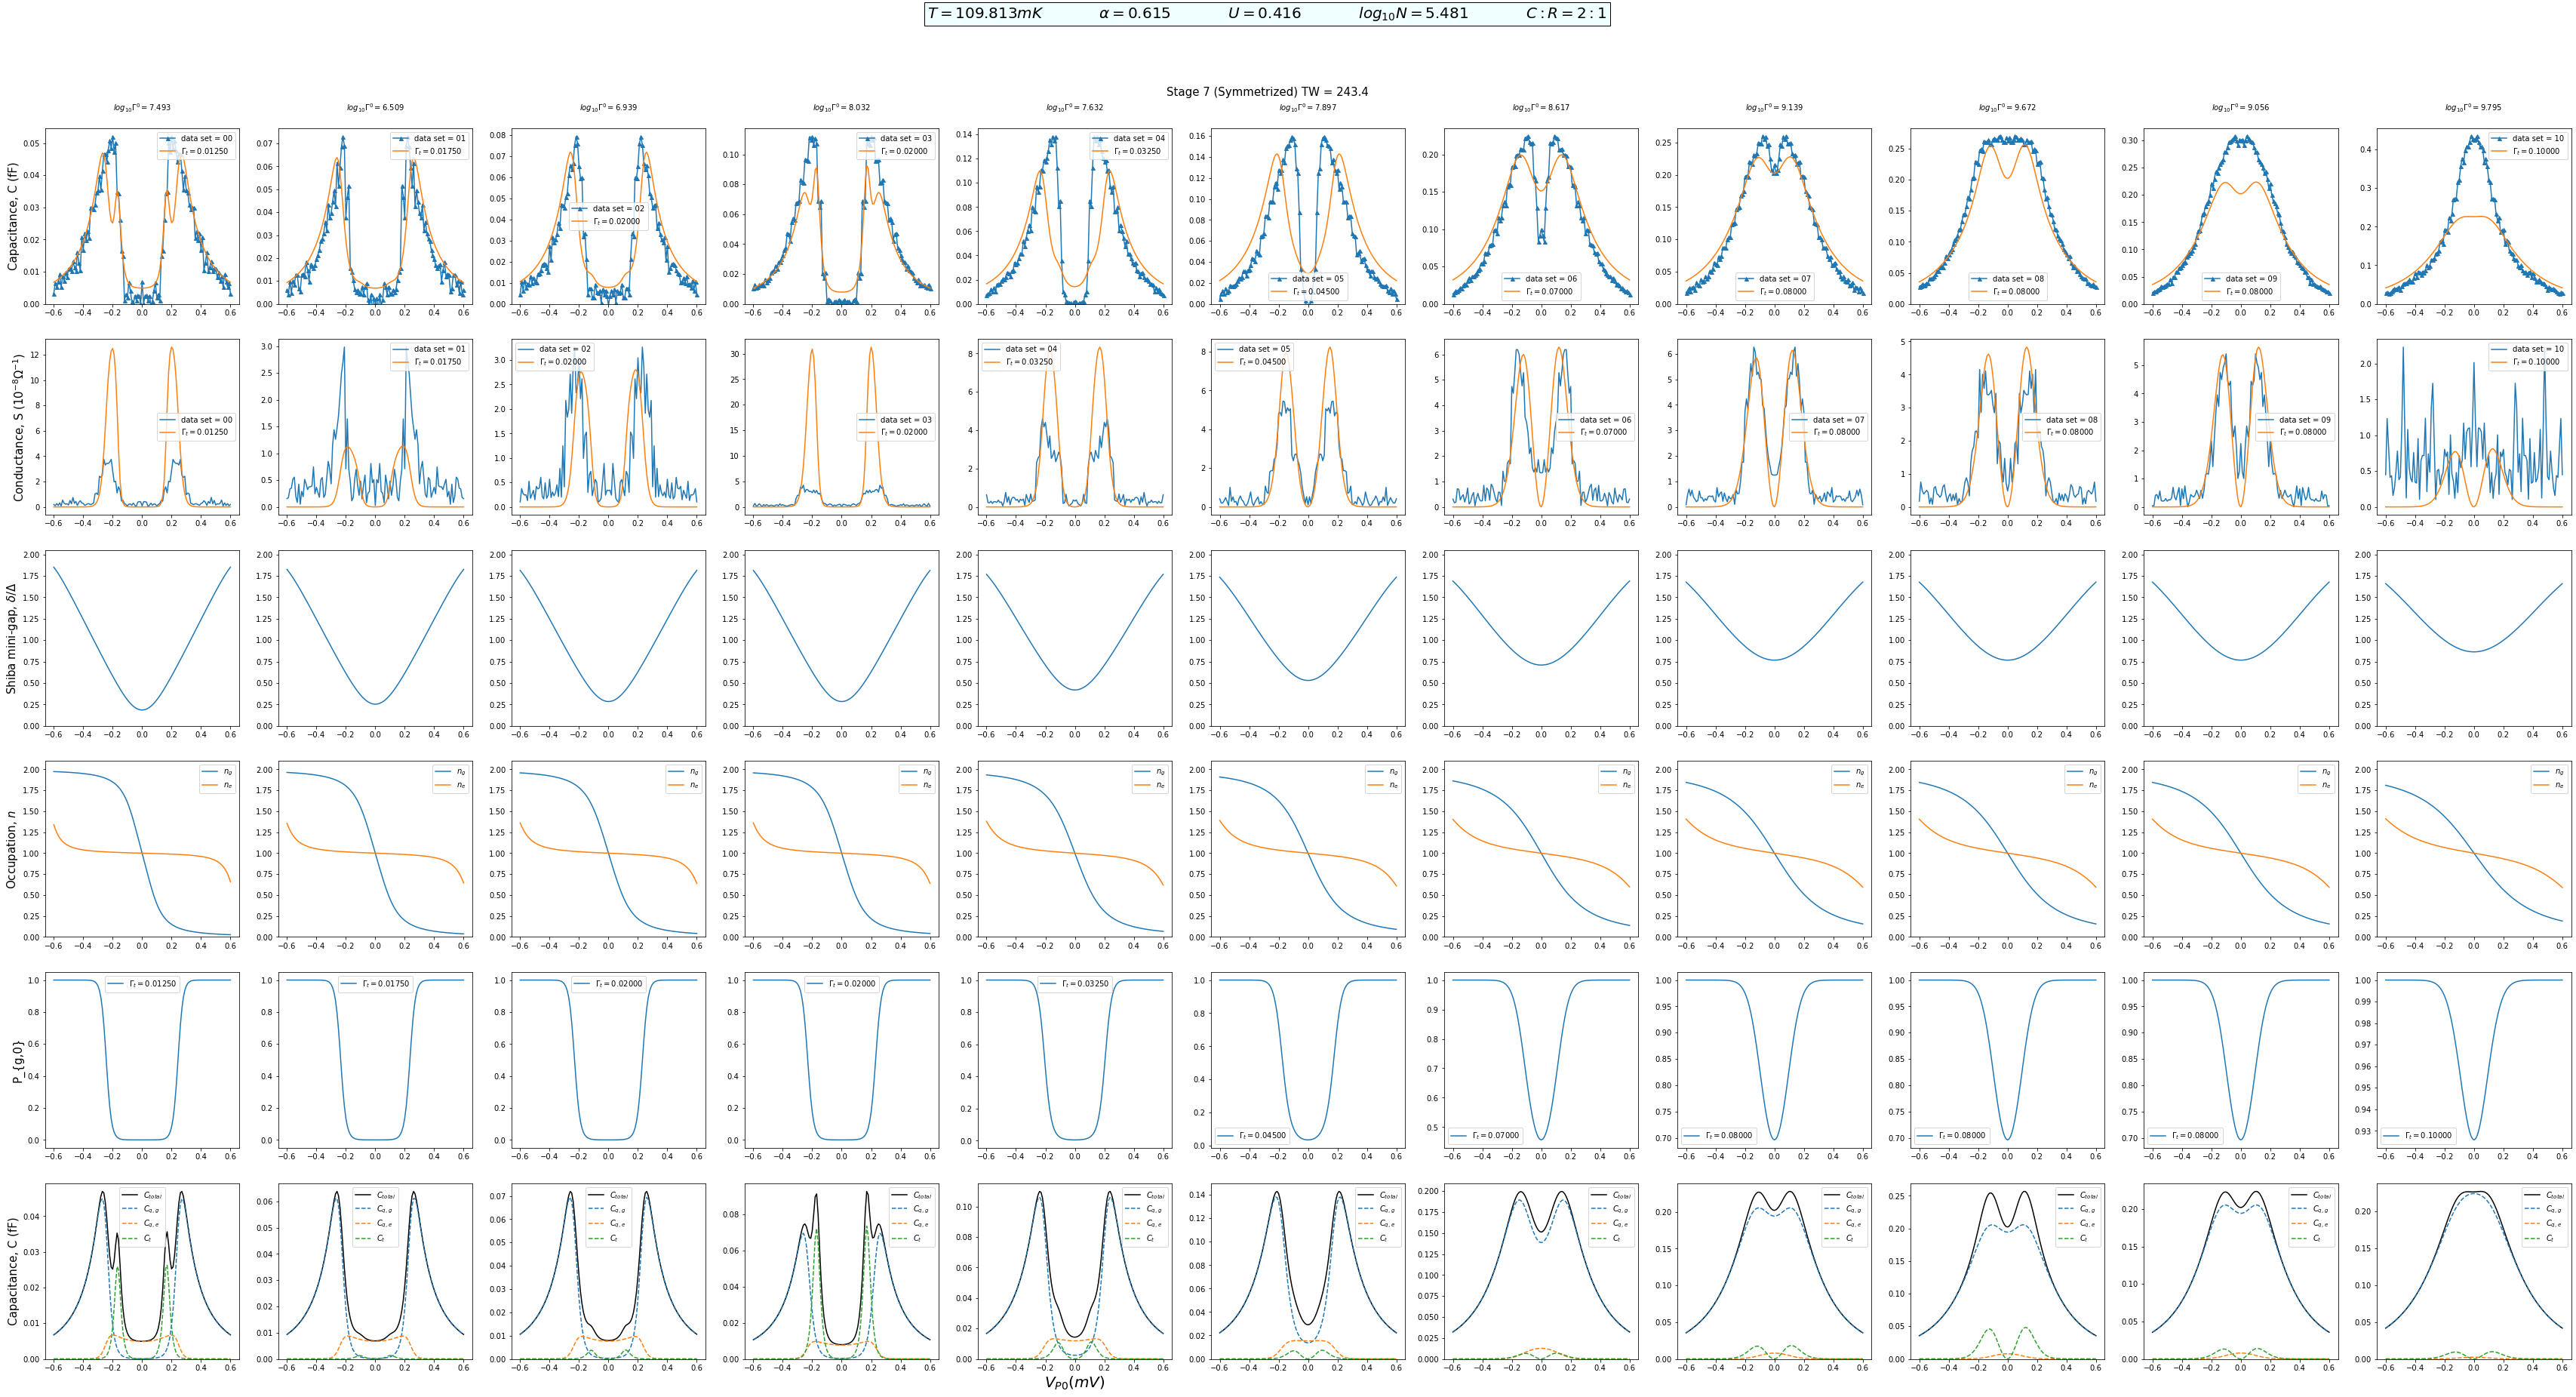

In [118]:
min_idx = 0
gridplotfit_v4(bigresh[min_idx][2],1,Uset[min_idx+3],True)

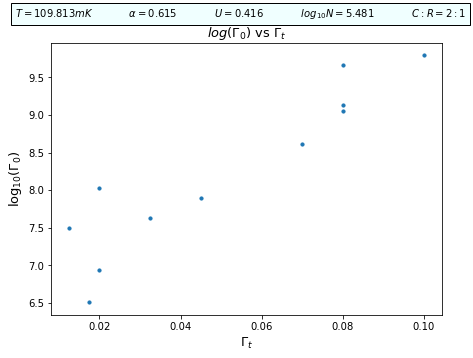

In [98]:
plt.close()

fig, axis = plt.subplots(1,1,figsize=(7,5))
reslist =  bigresh[0][2] #[7.18782493,  6.53997609,  6.95178355,  7.42629289,  7.43277345,
                               #7.83795479,  8.67289453,  9.11521502,  9.64710981,  9.04068084,
                               #8.85824842,  0.62466789, 11.27579307,  5.69590558] #bigresh[min_idx][2]
Uval = Uset[3]
*_,alpha,T,fac = reslist
*g0set, _, _, _ = reslist #bigresh[min_idx][2]
allweightset = [float(total_weight_s7(Uval,dset_list2[idx],10**g0set[idx],alpha,T/100,10**fac,1)[0]) for idx in range(len(dset_list2))]
g0set = np.array(g0set)
axis.scatter(allweightset,np.log10(10**g0set),s=10)
axis.set_xlabel('$\Gamma_t$',fontsize=13)
axis.set_ylabel('$\log_{10}(\Gamma_0)$',fontsize=13)
axis.set_title('$log(\Gamma_0)$ vs $\Gamma_t$',fontsize=13)
parameter_string = f"$T = {T*10:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {Uval:.3f} $\
            $log_{{10}} N   = {fac:.3f}$\
            $C:R = {2}:{1}$"
    
fig.text(
        0.5, 0.96, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=10)


# plt.savefig(f"logG0 vs Gt {[f'{member[0]}{member[1]:.2f}' for member in zip(['g0','a','T','N'],reslist)]}.jpg", format='jpg')

plt.savefig(f"2c1r logG0 vs Gt_U{Uval}_log10_Go-{np.mean(reslist[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],reslist[-3:])]}.svg", format='svg')
plt.savefig(f"2c1r logG0 vs Gt_U{Uval}_log10_Go-{np.mean(reslist[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],reslist[-3:])]}.pdf", format='pdf')


In [99]:
from scipy.stats import linregress


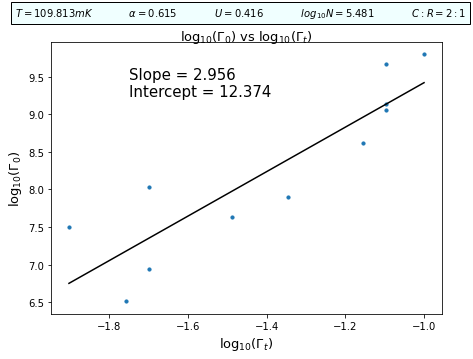

In [100]:
plt.close()

fig, axis = plt.subplots(1,1,figsize=(7,5))
Uval = Uset[3]
reslist = bigresh[0][2] #[7.18782493,  6.53997609,  6.95178355,  7.42629289,  7.43277345,
#                                7.83795479,  8.67289453,  9.11521502,  9.64710981,  9.04068084,
#                                8.85824842,  0.62466789, 11.27579307,  5.69590558] #bigresh[min_idx][2]
*_,alpha,T,fac = reslist
*g0set, _, _, _ = reslist #bigresh[min_idx][2]
allweightset = [float(total_weight_s7(Uval,dset_list2[idx],10**g0set[idx],alpha,T/100,10**fac,1)[0]) for idx in range(len(dset_list2))]
g0set = np.array(g0set)

slope, intercept, _, _, _ = linregress(np.log10(allweightset), np.log10(10**g0set))

axis.scatter(np.log10(allweightset),np.log10(10**g0set),s=10)
gammat_range = np.log10(np.linspace(np.min(allweightset),np.max(allweightset),100))
axis.plot(gammat_range,slope*gammat_range + intercept,'k')
axis.text(0.2,0.8,f'Slope = {slope:.3f}\nIntercept = {intercept:.3f}',transform=axis.transAxes,fontsize=15)
axis.set_xlabel('$\log_{10}(\Gamma_t)$',fontsize=13)
axis.set_ylabel('$\log_{10}(\Gamma_0)$',fontsize=13)
axis.set_title('$\log_{10}(\Gamma_0)$ vs $\log_{10}(\Gamma_t)$',fontsize=13,y=0.985)
parameter_string = f"$T = {T*10:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {Uval:.3f} $\
            $log_{{10}} N   = {fac:.3f}$\
            $C:R = {2}:{1}$"
    
fig.text(
        0.5, 0.96, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=10)
# plt.savefig(f"lnG0 vs lnGt_U.jpg", format='jpg')

# plt.savefig(r'C:\Users\rupes\Downloads\Temporary files\lnln.jpg')
# plt.savefig(f"2c1r logG0 vs logGt_U{Uval}_log10_Go-{np.mean(reslist[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],reslist[-3:])]}.svg", format='svg')
# plt.savefig(f"2c1r logG0 vs logGt_U{Uval}_log10_Go-{np.mean(reslist[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],reslist[-3:])]}.pdf", format='pdf')


In [ ]:
min_idx = 2
trial_vals = np.arange(1,10,0.1)
weiths = [total_set_weight_s7((*bigresh[min_idx][2][:-1],trial_valsss),1,Uset[min_idx]) for trial_valsss in trial_vals]
plt.plot(trial_vals,weiths)


In [ ]:
# # RENAME CODE

# For U Dirs
# # # for file_names in os.listdir(dirpath):
# # #     if file_names[0:2]=='U=':
# # #         os.rename(dirpath+file_names,dirpath+f'{file_names[:4]}{int(file_names[4:]):<03d}')

# For Gt dirs
# # # dirpath = f"f1web.ijs.si\\~zitko\\data\\chi\\"
# # # Uset = tuple(np.sort([file_names[2:] for file_names in os.listdir(dirpath) if file_names[0:2]=='U=']))

# # # Gamma_dict = list([list([file_names.split('=')[-1]
# # #                          for file_names in os.listdir(dirpath+f'U={Uvals}')
# # #                          if file_names[0:2]=='U=']) for Uvals in Uset])
# # # for idx1, usets in enumerate(Gamma_dict):
# # #     for idx2, gammavals in enumerate(usets):
# # #         filepath = f"U={Uset[idx1]}\\U={Uset[idx1]}_Gamma="
# # #         oldpath = dirpath+filepath+gammavals
# # #         newpath = dirpath+filepath + f'{gammavals[:-1]}{int(gammavals[-1]):<010d}'[:7]
# # #         os.rename(oldpath,newpath)


In [ ]:
# dirpath = f"f1web.ijs.si\\~zitko\\data\\chi\\"
# # Uset = list(np.sort([file_names[2:] for file_names in os.listdir(dirpath) if file_names[0:2]=='U=']))

# # Gamma_dict = {} #Dict.empty(key_type = types.unicode_type, value_type = types.float64[:])
# optical1_data = Dict.empty(key_type = types.unicode_type, value_type = types.float64[:,:,:])
# # n1_data = Dict.empty(key_type = types.unicode_type, value_type = types.float64[:,:,:])
# # n2_data = Dict.empty(key_type = types.unicode_type, value_type = types.float64[:,:,:])

# # for Uvals in Uset:
# #     Gamma_dict(Uvals) = np.array([file_names.split('=')[-1]
# #                          for file_names in os.listdir(dirpath+f'U={Uvals}')
# #                          if file_names[0:2]=='U='])
    
# # Gamma_dict['1.0'].remove('0.005') # this data file is incomplete

# for Uvals in Uset:
#     optical1_data[Uvals] = np.array(
#         [
#             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
#             for gammaa in Gamma_dict_func(Uvals)
#         ]
#     )
# #     n1_data[Uvals] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
# #             for gammaa in Gamma_dict[Uvals]
# #         ]
# #     )
# #     n2_data[Uvals] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
# #             for gammaa in Gamma_dict[Uvals]
# #         ]
# #     )

# # n1_data       = {Uvals:np.array([np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400] 
# #                                  for gammaa in Gamma_dict[Uvals]]) 
# #                  for Uvals in Uset}
# # n2_data       = {Uvals:np.array([np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400] 
# #                                  for gammaa in Gamma_dict[Uvals]]) 
# #                  for Uvals in Uset}

In [ ]:
# 
# # Udtype = np.dtype([(f'U{Uvals}', np.float64, (len(Gamma_dict_func(Uvals)),400)) for Uvals in Uset])
# # optical1_data = np.zeros(2,dtype=Udtype)
# # n1_data = np.zeros(2,dtype=Udtype)
# # n2_data = np.zeros(2,dtype=Udtype)

# # for Uvals in Uset:
# #     optical1_data[f'U{Uvals}'][0,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,0]
# #     optical1_data[f'U{Uvals}'][1,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,1]
    
# #     n1_data[f'U{Uvals}'][0,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,0]
# #     n1_data[f'U{Uvals}'][1,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,1]
    
# #     n2_data[f'U{Uvals}'][0,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,0]
# #     n2_data[f'U{Uvals}'][1,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,1]